In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T

import torch
import torch.nn as nn
import torch.nn.functional as F

from model import *

In [2]:
file_name = 'mimmo/mimmo.h5'
hf = h5py.File(file_name,'r')

print('Keys: ', list(hf.keys()))
print('Attrs: ', dict(hf.attrs),'\n')
print(hf['ismrmrd_header'])
print(hf['kspace'])
print(hf['reconstruction_esc'])
print(hf['reconstruction_rss'])

Keys:  ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs:  {'acquisition': 'CORPDFS_FBK', 'max': 0.000851878253624366, 'norm': 0.0596983310320022, 'patient_id': '0beb8905d9b7fad304389b9d4263c57d5b069257ea0fdc5bf7f2675608a47406'} 

<HDF5 dataset "ismrmrd_header": shape (), type "|O">
<HDF5 dataset "kspace": shape (36, 640, 372), type "<c8">
<HDF5 dataset "reconstruction_esc": shape (36, 320, 320), type "<f4">
<HDF5 dataset "reconstruction_rss": shape (36, 320, 320), type "<f4">


In [3]:
volume_kspace = hf['kspace'][()]     #Takes all the kspace
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(36, 640, 372)


In [4]:
#Takes single layer of the kspace image
slice_kspace = volume_kspace[35] #Ogni valore tra 0-35 ritorna un'immagine diversa
print(slice_kspace.shape,volume_kspace.shape)

(640, 372) (36, 640, 372)


(640, 372)


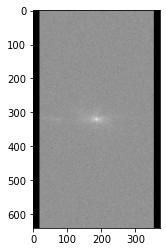

In [5]:
def show_coils(data, cmap=None): #Shows image in kspace
    fig = plt.figure()
    print(data.shape)
    plt.imshow(data, cmap=cmap)
    
show_coils(np.log(np.abs(slice_kspace) + 1e-9),cmap='gray')

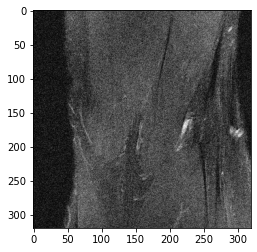

In [6]:
ricostruzione_esc = hf['reconstruction_esc'][35]
fig = plt.figure()
plt.imshow(ricostruzione_esc, cmap='gray') #The real image already reconstructed from kspace (FULLY SAMPLED)

In [7]:
#print(slice_kspace.shape)
#print(T.to_tensor(slice_kspace).shape)

In [8]:
from fastmri.data.subsample import RandomMaskFunc

mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])

#TODO: CROP THE SLICE KSPACE HERE?
#crop_kspace = T.complex_center_crop(T.to_tensor(slice_kspace), (320,320))

masked_kspace, mask = T.apply_mask(T.to_tensor(slice_kspace), mask_func)   # Apply the mask to k-space

sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
#sampled_image = T.complex_center_crop(sampled_image, (320,320))
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image

print("sampled_image, ",sampled_image.shape)
print("sampled_image_abs, ",sampled_image_abs.shape)
print("mask, ",mask.shape)
print("masked_kspace, ",masked_kspace.shape)

figura = fastmri.ifft2c(T.to_tensor(slice_kspace))

#fig = plt.figure()
#plt.imshow(sampled_image_abs, cmap='gray')

sampled_image,  torch.Size([640, 372, 2])
sampled_image_abs,  torch.Size([640, 372])
mask,  torch.Size([1, 372, 1])
masked_kspace,  torch.Size([640, 372, 2])


In [ ]:
mimmo = Net()

espandi = sampled_image.unsqueeze(0).unsqueeze(0)
espandi2 = figura.unsqueeze(0).unsqueeze(0)
print(espandi.shape)
#ricos = T.to_tensor(ricostruzione_esc).unsqueeze(0).unsqueeze(0)
#print(ricos.shape)
mimmone = mimmo(espandi,espandi2,mask)

torch.Size([1, 1, 640, 372, 2])
1 temp shape --------->,  torch.Size([1, 16, 160, 93, 2])


In [ ]:
print(mimmone.shape)

figuraoutput = mimmone.squeeze(0).squeeze(0)

sampled_image = fastmri.ifft2c(figuraoutput)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image

fig = plt.figure()
plt.imshow(sampled_image_abs.detach().numpy(), cmap='gray')